In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from scipy import optimize
from scipy.stats import sem

import os
import sys

import matplotlib.pyplot as plt
import matplotlib.ticker
from venn import venn, pseudovenn
import seaborn as sns
from matplotlib.collections import PathCollection

from Bio import SeqIO, SeqUtils
from Bio.SeqUtils.ProtParam import ProteinAnalysis

from addict import Dict
import json

import matplotlib.ticker as mticker
import matplotlib.cm as cm
from matplotlib.patches import Rectangle, Patch

In [3]:
sys.path.append("../")
import plotting as my_plot

sys.path.append("./mean_field_elect/")
import proteomics_functions as prot_fun

# Load data

In [4]:
df_master = pd.read_csv('./generated_tables/swath_master_df_ppm.csv')

# Get rid of CHO species specification and ad hoc add accn to name
for i, cont in df_master.iterrows():
    name = cont['name']
    new_name = name[:1].upper() + name[1:-21]
    if new_name == '10 kDa heat shock protein, mitochondrial':
        new_name += ' '
        new_name += cont.accn
    df_master.at[i, 'name'] = new_name

df_master.set_index('name', inplace=True)

In [6]:
df_plot = df_master[['hccf_feed', 'hccf_large', 'hccf_small', 'hccf_mab', 'hccf_spf1', 'hccf_spf2', 'pavin_feed', 'pavin_large', 'pavin_small', 'pavin_mab']]
df_plot.columns = ['HCCF Feed', 'HCCF Large agg.', 'HCCF Small agg.', 'HCCF mAb', 'HCCF SPF 1', 'HCCF SPF 2', 'PAVIN Feed', 'PAVIN Large agg.', 'PAVIN Small agg.', 'PAVIN mAb']

# All data

In [7]:
proteases = [name for name in df_plot.index if 'protease' in name.lower() and 'binding' not in name.lower() and 'enhancer' not in name.lower()]
proteases.sort()
proteinases = [name for name in df_plot.index if 'proteinase' in name.lower() and 'binding' not in name.lower() and 'enhancer' not in name.lower()]
proteinases.sort()
cathepsins = [name for name in df_plot.index if 'cathepsin' in name.lower() and 'binding' not in name.lower() and 'enhancer' not in name.lower()]
cathepsins.sort()
peptidases = [name for name in df_plot.index if 'peptidase' in name.lower() and 'binding' not in name.lower() and 'enhancer' not in name.lower()]
peptidases.sort()
proteasomes = [name for name in df_plot.index if 'proteasome' in name.lower() and 'binding' not in name.lower() and 'chaperone' not in name.lower()]
proteasomes.sort()
all_proteases = proteases + proteinases + cathepsins + peptidases + proteasomes
assert(len(all_proteases) == len([*set(all_proteases)]))

lipases = [name for name in df_plot.index if 'lipase' in name.lower() and 'binding' not in name.lower() and 'enhancer' not in name.lower()]
lipases.sort()
phsopholipases = [name for name in df_plot.index if 'phsopholipase' in name.lower() and 'binding' not in name.lower() and 'enhancer' not in name.lower()]
phsopholipases.sort()
hydrolases = [name for name in df_plot.index if 'hydrolase' in name.lower() and 'binding' not in name.lower() and 'enhancer' not in name.lower()]
hydrolases.sort()
esterases = [name for name in df_plot.index if 'esterase' in name.lower() and 'binding' not in name.lower() and 'enhancer' not in name.lower()]
esterases.sort()
all_lipases_temp = lipases + hydrolases + esterases
all_lipases = []
for n in all_lipases_temp:
    if n not in all_lipases:
        all_lipases.append(n)
assert(len(all_lipases) == len([*set(all_lipases)]))

glucosidases = [name for name in df_plot.index if 'cosidase' in name.lower() and 'binding' not in name.lower() and 'enhancer' not in name.lower()] 
glucosidases.sort()
galactosidases = [name for name in df_plot.index if 'galactosidase' in name.lower() and 'binding' not in name.lower() and 'enhancer' not in name.lower()] 
galactosidases.sort()
glucuronidases = [name for name in df_plot.index if 'glucuronidase' in name.lower() and 'binding' not in name.lower() and 'enhancer' not in name.lower()] 
glucuronidases.sort()
mannosidases = [name for name in df_plot.index if 'mannosidase' in name.lower() and 'binding' not in name.lower() and 'enhancer' not in name.lower()] 
mannosidases.sort()
fucosidases = [name for name in df_plot.index if 'fucosidase' in name.lower() and 'binding' not in name.lower() and 'enhancer' not in name.lower()] 
fucosidases.sort()
sialidases = [name for name in df_plot.index if 'sialidase' in name.lower() and 'binding' not in name.lower() and 'enhancer' not in name.lower()] 
sialidases.sort()
all_glucosidases_temp = glucosidases + galactosidases + glucuronidases + mannosidases + fucosidases + sialidases
all_glucosidases = []
for n in all_glucosidases_temp:
    if n not in all_glucosidases:
        all_glucosidases.append(n)
assert(len(all_glucosidases) == len([*set(all_glucosidases)]))

histones = ['Core histone macro-H2A.1 isoform X6',
            'Histone H2B type 1',
            'Nucleosome assembly protein 1-like 4 isoform X2',
            'Nucleosome assembly protein 1-like 1 isoform X2']

ribosomes = [name for name in df_plot.index if 'ribosom' in name.lower() and 'binding' not in name.lower() and 'transferase' not in name.lower() and 'enhancer' not in name.lower()] 
ribosomes.sort()

heat_shock = [name for name in df_plot.index if 'heat shock' in name.lower() and 'binding' not in name.lower() and 'enhancer' not in name.lower()] 
heat_shock.sort()

chaperones = [name for name in df_plot.index if 'chaperone' in name.lower() and 'regulator' not in name.lower() and 'enhancer' not in name.lower()] 
chaperones.sort()

peroxiredoxins = [name for name in df_plot.index if 'peroxiredoxin' in name.lower() and 'binding' not in name.lower() and 'enhancer' not in name.lower()] 
peroxiredoxins.sort()

glutathiones = [name for name in df_plot.index if 'glutathione s-transferase' in name.lower() and 'binding' not in name.lower() and 'enhancer' not in name.lower()] 
glutathiones.sort()

actins = [name for name in df_plot.index if 'actin' in name.lower() and 'interacting' not in name.lower()] 
actins.sort()

ubiquitins = [name for name in df_plot.index if 'ubiquitin' in name.lower() and 'receptor' not in name.lower()] 
ubiquitins.sort()

protein_lists = [all_proteases, all_glucosidases, all_lipases, histones, ribosomes, heat_shock, chaperones, peroxiredoxins, actins, glutathiones]
combined = []
for l in protein_lists:
    combined += l
assert(len(combined) == len([*set(combined)]))

In [8]:
sorted_names = []
sorted_protein_lists = []

for l in protein_lists:
    df_temp = df_plot.loc[l].copy()
    df_temp.sort_values(by=['HCCF Large agg.', 'PAVIN Large agg.', 'HCCF Small agg.', 'PAVIN Small agg.', 'HCCF SPF 1', 
                            'HCCF mAb', 'HCCF SPF 2', 'HCCF Feed', 'PAVIN Feed', 'PAVIN mAb'],
                        inplace=True, ascending=False)
    for n in df_temp.index:
        sorted_names.append(n)
    sorted_protein_lists.append(list(df_temp.index))

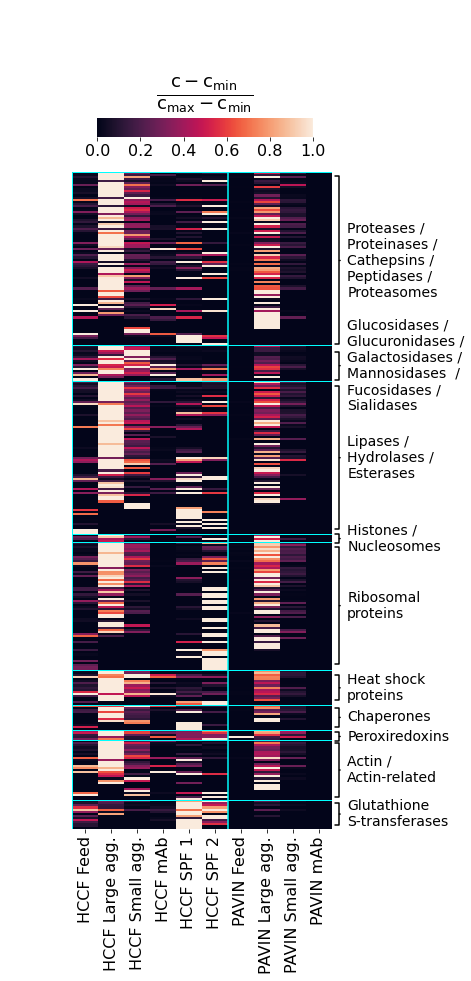

In [11]:
ax = sns.clustermap(df_plot.loc[sorted_names], method='ward', standard_scale=0, figsize=(5, 13), yticklabels=False, col_cluster=False, row_cluster=False,
                   cbar_pos=(0.28, 0.85, 0.6, 0.02), cbar_kws={'orientation':'horizontal'})

fontsize = 16
rotation = 90

# Set xtick labels
real_ax = ax.ax_heatmap
real_ax.set_xticklabels(real_ax.get_xmajorticklabels(), rotation=rotation, ha='right', va='center', rotation_mode='anchor', fontsize=fontsize)
real_ax.set_ylabel(None)

# Set color bar
cbar_text = ax.ax_cbar.set_title(r'$\mathsf{\frac{c - c_{min}}{c_{max} - c_{min}}}$', fontsize=26, pad=15)
label_format = '{:,.1f}'
ticks_loc = ax.ax_cbar.get_xticks().tolist()
_ = ax.ax_cbar.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
_ = ax.ax_cbar.set_xticklabels([label_format.format(x) for x in ticks_loc], fontsize=fontsize)
cbar_col_labels = ax.ax_heatmap.set_xticklabels(ax.ax_heatmap.get_xmajorticklabels(), fontsize = fontsize)

# Set boxes
heat = ax.ax_heatmap
r = heat.add_patch(Rectangle((6, 0), 0, len(df_plot.loc[sorted_names]), fill=False, edgecolor='cyan', lw=1.5))

cnt = 0
for protein_list in protein_lists:
    r = heat.add_patch(Rectangle((0, cnt), 10, len(protein_list), fill=False, edgecolor='cyan', lw=1))
    cnt += len(protein_list)

# Add group annotations
text_1 = heat.annotate('Proteases /\nProteinases /\nCathepsins /\nPeptidases /\nProteasomes', xy=(1.03, 0.865), xytext=(1.06, 0.865), xycoords='axes fraction', ha='left', 
                       va='center', arrowprops=dict(arrowstyle='-[, widthB=6.0, lengthB=0.3', lw=1.5), fontsize=14, 
                       bbox=dict(pad=5, facecolor="none", edgecolor="none"))

text_1 = heat.annotate('Glucosidases /\nGlucuronidases /\nGalactosidases /\nMannosidases  /\nFucosidases /\nSialidases', 
                       xy=(1.03, 0.705), xytext=(1.06, 0.705), xycoords='axes fraction', ha='left', 
                       va='center', arrowprops=dict(arrowstyle='-[, widthB=1.0, lengthB=0.3', lw=1.5), fontsize=14, 
                       bbox=dict(pad=5, facecolor="none", edgecolor="none"))

text_1 = heat.annotate('Lipases /\nHydrolases /\nEsterases', xy=(1.03, 0.565), xytext=(1.06, 0.565), xycoords='axes fraction', ha='left', 
                       va='center', arrowprops=dict(arrowstyle='-[, widthB=5.1, lengthB=0.3', lw=1.5), fontsize=14, 
                       bbox=dict(pad=5, facecolor="none", edgecolor="none"))

text_1 = heat.annotate('Histones /\nNucleosomes', xy=(1.03, 0.442), xytext=(1.06, 0.442), xycoords='axes fraction', ha='left', 
                       va='center', arrowprops=dict(arrowstyle='-[, widthB=0.3, lengthB=0.3', lw=1.5), fontsize=14, 
                       bbox=dict(pad=5, facecolor="none", edgecolor="none"))

text_1 = heat.annotate('Ribosomal\nproteins', xy=(1.03, 0.34), xytext=(1.06, 0.34), xycoords='axes fraction', ha='left', 
                       va='center', arrowprops=dict(arrowstyle='-[, widthB=4.2, lengthB=0.3', lw=1.5), fontsize=14, 
                       bbox=dict(pad=5, facecolor="none", edgecolor="none"))

text_1 = heat.annotate('Heat shock\nproteins', xy=(1.03, 0.215), xytext=(1.06, 0.215), xycoords='axes fraction', ha='left', 
                       va='center', arrowprops=dict(arrowstyle='-[, widthB=0.9, lengthB=0.3', lw=1.5), fontsize=14, 
                       bbox=dict(pad=5, facecolor="none", edgecolor="none"))

text_1 = heat.annotate('Chaperones', xy=(1.03, 0.17), xytext=(1.06, 0.17), xycoords='axes fraction', ha='left', 
                       va='center', arrowprops=dict(arrowstyle='-[, widthB=0.65, lengthB=0.3', lw=1.5), fontsize=14, 
                       bbox=dict(pad=5, facecolor="none", edgecolor="none"))

text_1 = heat.annotate('Peroxiredoxins', xy=(1.03, 0.141), xytext=(1.06, 0.141), xycoords='axes fraction', ha='left', 
                       va='center', arrowprops=dict(arrowstyle='-[, widthB=0.3, lengthB=0.3', lw=1.5), fontsize=14, 
                       bbox=dict(pad=5, facecolor="none", edgecolor="none"))

text_1 = heat.annotate('Actin /\nActin-related', xy=(1.03, 0.09), xytext=(1.06, 0.09), xycoords='axes fraction', ha='left', 
                       va='center', arrowprops=dict(arrowstyle='-[, widthB=1.9, lengthB=0.3', lw=1.5), fontsize=14, 
                       bbox=dict(pad=5, facecolor="none", edgecolor="none"))

text_1 = heat.annotate('Glutathione\nS-transferases', xy=(1.03, 0.017 + 0.006), xytext=(1.06, 0.017 + 0.006), xycoords='axes fraction', ha='left', 
                       va='center', arrowprops=dict(arrowstyle='-[, widthB=0.8, lengthB=0.3', lw=1.5), fontsize=14, 
                       bbox=dict(pad=5, facecolor="none", edgecolor="none"))

ax.savefig(f'./images/17_swath_selected_species_heat_map.png', dpi=300, bbox_inches='tight', facecolor='white', transparent=False)
ax.savefig(f'./images/17_swath_selected_species_heat_map.tif', dpi=300, bbox_inches='tight', facecolor='white', transparent=False)
ax.savefig(f'./images/17_swath_selected_species_heat_map.eps', dpi=300, bbox_inches='tight')